In [8]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

IN_PATH = Path("../artifact/core10/core10_04_survivability_scores.csv")
assert IN_PATH.exists(), f"Input not found: {IN_PATH.resolve()}"

df = pd.read_csv(IN_PATH)
print("loaded rows:", len(df))
print("columns:", df.columns.tolist())

EQUIRED = [
    "antibody_id",
    "signature",
    "core10_operational_risk",
    "proxy_survivability_score",
    "tie_break_risk",
    "logit_safe_prob",
    "tree_safe_prob",
    "cluster_size",
    "hc_subtype",
    "lc_subtype",
]
missing = [c for c in REQUIRED if c not in df.columns]
assert not missing, f"Missing columns: {missing}"

# dtype normalize
num_cols = [
    "core10_operational_risk",
    "proxy_survivability_score",
    "tie_break_risk",
    "logit_safe_prob",
    "tree_safe_prob",
    "cluster_size",
]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["cluster_size"] = df["cluster_size"].fillna(0).astype(int)

df.head(10)

loaded rows: 19
columns: ['antibody_id', 'signature', 'core10_operational_risk', 'proxy_survivability_score', 'tie_break_risk', 'logit_safe_prob', 'hazard_logit', 'tree_safe_prob', 'hazard_tree', 'hc_subtype', 'lc_subtype', 'cluster_size']


,antibody_id,signature,core10_operational_risk,proxy_survivability_score,tie_break_risk,logit_safe_prob,hazard_logit,tree_safe_prob,hazard_tree,hc_subtype,lc_subtype,cluster_size
0,GDPa1-060,IgG1|Kappa|0,0.156673,0.858995,1.308744,0.873860,0.126140,1.0,LOW,IgG1,Kappa,54
1,GDPa1-085,IgG1|Kappa|4,0.172660,0.844606,1.234429,0.919651,0.080349,1.0,LOW,IgG1,Kappa,49
2,GDPa1-021,IgG1|Kappa|1,0.172660,0.844606,1.244671,0.842986,0.157014,1.0,LOW,IgG1,Kappa,49
3,GDPa1-025,IgG1|Lambda|4,0.172660,0.844606,1.335000,0.776621,0.223379,1.0,LOW,IgG1,Lambda,49
4,GDPa1-165,IgG1|Lambda|1,0.172660,0.844606,1.350459,0.818172,0.181828,1.0,LOW,IgG1,Lambda,49
5,GDPa1-017,IgG1|Kappa|2,0.176257,0.841369,1.154242,0.938738,0.061262,1.0,LOW,IgG1,Kappa,48
6,GDPa1-010,IgG1|Kappa|3,0.183920,0.834472,1.336067,0.531072,0.468928,0.0,HIGH,IgG1,Kappa,46
7,GDPa1-138,IgG4|Kappa|0,0.549561,0.505395,1.335473,0.457319,0.542681,0.0,HIGH,IgG4,Kappa,54
8,GDPa1-050,IgG4|Kappa|4,0.565548,0.491007,1.426338,0.132322,0.867678,0.0,HIGH,IgG4,Kappa,49
9,GDPa1-039,IgG4|Kappa|1,0.565548,0.491007,1.510580,0.040565,0.959435,0.0,HIGH,IgG4,Kappa,49


 실제 failure/성능 라벨이 없으므로 "운영 위험"을 기준으로 pseudo-failure를 정의한다.
 - pseudo_failure = 1 : 운영상 위험이 큰 집단 (추가 설계 필요 가능성이 높다고 가정)
 - pseudo_failure = 0 : 상대적으로 덜 위험한 집단

운영 비용 캘리브레이션을 위한 계약(operational surrogate)이다.


 Cost policy (운영 비용) - 이게 Core10의 '정책 파라미터'
 오탐(FP): 안전한데 위험하다고 보고 너무 일찍 버림 -> 운영 자원 손실
 미탐(FN): 위험한데 안전하다고 보고 계속 운영 -> 폭주/재설계/사고 비용

In [9]:
df["hazard_rule"]  = (1.0 - df["proxy_survivability_score"]).clip(0, 1)
df["hazard_logit"] = (1.0 - df["logit_safe_prob"]).clip(0, 1)
df["hazard_tree"]  = (1.0 - df["tree_safe_prob"]).clip(0, 1)

# 옵션 B: Rule + Tie-break 결합 위험 (Core10스럽게: 운영 관리 난이도)
df["composite_hazard"] = (0.7 * df["hazard_rule"] + 0.3 * df["tie_break_risk"]).clip(0, 1)


In [10]:
CAL_RULE_ID = "core10_05_cost_calibration_v1"
PSEUDO_FAIL_QUANTILE = 0.30  # 상위 30%를 pseudo-failure로 간주

# --- Option A ---
fail_th_A = df["hazard_rule"].quantile(1.0 - PSEUDO_FAIL_QUANTILE)
df["pseudo_failure_A"] = (df["hazard_rule"] >= fail_th_A).astype(int)

# --- Option B ---
fail_th_B = df["composite_hazard"].quantile(1.0 - PSEUDO_FAIL_QUANTILE)
df["pseudo_failure_B"] = (df["composite_hazard"] >= fail_th_B).astype(int)

print("PSEUDO_FAIL_QUANTILE:", PSEUDO_FAIL_QUANTILE)
print("[A] fail_th_A (hazard_rule >=):", float(fail_th_A))
print(df["pseudo_failure_A"].value_counts())
print()
print("[B] fail_th_B (composite_hazard >=):", float(fail_th_B))
print(df["pseudo_failure_B"].value_counts())

# 스위프에 쓸 라벨 선택 (A 또는 B)
PSEUDO_MODE = "A"  # "A" or "B"
LABEL_COL = "pseudo_failure_A" if PSEUDO_MODE.upper() == "A" else "pseudo_failure_B"
FAIL_TH   = float(fail_th_A) if PSEUDO_MODE.upper() == "A" else float(fail_th_B)

print("\n✅ Using PSEUDO_MODE =", PSEUDO_MODE, "| LABEL_COL =", LABEL_COL, "| FAIL_TH =", FAIL_TH)

df[["antibody_id", LABEL_COL, "hazard_rule", "hazard_logit", "hazard_tree", "composite_hazard"]].head(10)

PSEUDO_FAIL_QUANTILE: 0.3
[A] fail_th_A (hazard_rule >=): 0.7329374671571203
pseudo_failure_A
0    13
1     6
Name: count, dtype: int64

[B] fail_th_B (composite_hazard >=): 0.9237876944869656
pseudo_failure_B
0    13
1     6
Name: count, dtype: int64

✅ Using PSEUDO_MODE = A | LABEL_COL = pseudo_failure_A | FAIL_TH = 0.7329374671571203


,antibody_id,pseudo_failure_A,hazard_rule,hazard_logit,hazard_tree,composite_hazard
0,GDPa1-060,0,0.141005,0.126140,0.0,0.491327
1,GDPa1-085,0,0.155394,0.080349,0.0,0.479104
2,GDPa1-021,0,0.155394,0.157014,0.0,0.482177
3,GDPa1-025,0,0.155394,0.223379,0.0,0.509276
4,GDPa1-165,0,0.155394,0.181828,0.0,0.513913
5,GDPa1-017,0,0.158631,0.061262,0.0,0.457314
6,GDPa1-010,0,0.165528,0.468928,1.0,0.516690
7,GDPa1-138,0,0.494605,0.542681,1.0,0.746865
8,GDPa1-050,0,0.508993,0.867678,1.0,0.784197
9,GDPa1-039,0,0.508993,0.959435,1.0,0.809469


In [11]:
COST_FP = 1.0
COST_FN = 5.0

# 안정성 페널티: threshold sweep에서 양성비율(pos_rate)이 급격히 변하면 운영 불리
STABILITY_WEIGHT = 0.25

# threshold grid
N_GRID = 101

print({
    "COST_FP": COST_FP,
    "COST_FN": COST_FN,
    "STABILITY_WEIGHT": STABILITY_WEIGHT,
    "N_GRID": N_GRID,
})

def confusion_and_cost(y_true, y_pred, cost_fp, cost_fn):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    tp = int(((y_true == 1) & (y_pred == 1)).sum())
    fp = int(((y_true == 0) & (y_pred == 1)).sum())
    tn = int(((y_true == 0) & (y_pred == 0)).sum())
    fn = int(((y_true == 1) & (y_pred == 0)).sum())

    base_cost = cost_fp * fp + cost_fn * fn
    return {"tp": tp, "fp": fp, "tn": tn, "fn": fn, "base_cost": float(base_cost)}

def stability_proxy(pred_pos_rate_series):
    r = np.asarray(pred_pos_rate_series, dtype=float)
    if len(r) < 2:
        return 0.0
    return float(np.mean(np.abs(np.diff(r))))

{'COST_FP': 1.0, 'COST_FN': 5.0, 'STABILITY_WEIGHT': 0.25, 'N_GRID': 101}


 Risk score definitions
 - Rule-based: hazard_rule = 1 - proxy_survivability_score
 - Logistic:   hazard_logit = 1 - logit_safe_prob
 - Tree:       hazard_tree  = 1 - tree_safe_prob
 All in [0,1] (clip for safety)


In [12]:
def sweep_thresholds(df, hazard_col, y_col, n_grid, cost_fp, cost_fn, stability_weight):
    thresholds = np.linspace(0.0, 1.0, n_grid)

    y_true = pd.to_numeric(df[y_col], errors="coerce").fillna(0).astype(int).values
    hazard = pd.to_numeric(df[hazard_col], errors="coerce").fillna(0.0).clip(0, 1).values

    rows = []
    pos_rates = []

    for th in thresholds:
        y_pred = (hazard >= th).astype(int)
        pos_rate = float(y_pred.mean())
        pos_rates.append(pos_rate)

        stats = confusion_and_cost(y_true, y_pred, cost_fp, cost_fn)
        rows.append({
            "pseudo_mode": PSEUDO_MODE,
            "label_col": y_col,
            "hazard_col": hazard_col,
            "threshold": float(th),
            "pos_rate": pos_rate,
            **stats
        })

    out = pd.DataFrame(rows)

    stab = stability_proxy(pos_rates)
    out["stability_proxy"] = stab
    out["total_cost"] = out["base_cost"] + stability_weight * stab * len(df)

    best_idx = out["total_cost"].idxmin()
    best = out.loc[best_idx].to_dict()
    return out, best

hazard_cols = ["hazard_rule", "hazard_logit", "hazard_tree"]

curves = []
best_rows = []

for hc in hazard_cols:
    curve_df, best = sweep_thresholds(
        df=df,
        hazard_col=hc,
        y_col=LABEL_COL,
        n_grid=N_GRID,
        cost_fp=COST_FP,
        cost_fn=COST_FN,
        stability_weight=STABILITY_WEIGHT
    )
    curves.append(curve_df)
    best_rows.append(best)

curve_all = pd.concat(curves, ignore_index=True)
best_df = pd.DataFrame(best_rows).sort_values("total_cost")

best_df

,pseudo_mode,label_col,hazard_col,threshold,pos_rate,tp,fp,tn,fn,base_cost,stability_proxy,total_cost
0,A,pseudo_failure_A,hazard_rule,0.52,0.315789,6,0,13,0,0.0,0.010000,0.0475
1,A,pseudo_failure_A,hazard_logit,0.91,0.368421,6,1,12,0,1.0,0.010000,1.0475
2,A,pseudo_failure_A,hazard_tree,0.01,0.684211,6,7,6,0,7.0,0.003158,7.0150


 Threshold sweep:
 predicted_failure = 1 if hazard >= threshold
 threshold in [0,1]


In [13]:
EXPORT_DIR = Path("../artifact/core10")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV  = EXPORT_DIR / "core10_05_cost_calibration.csv"
OUT_JSON = EXPORT_DIR / "core10_05_recommended_thresholds.json"

curve_all.to_csv(OUT_CSV, index=False)

recommended = {
    "rule_id": CAL_RULE_ID,
    "pseudo_mode": PSEUDO_MODE,
    "pseudo_label_contract": {
        "mode_A": {
            "label": "pseudo_failure_A",
            "definition": f"hazard_rule >= quantile({1.0 - PSEUDO_FAIL_QUANTILE})",
            "threshold_value": float(fail_th_A),
        },
        "mode_B": {
            "label": "pseudo_failure_B",
            "definition": f"composite_hazard >= quantile({1.0 - PSEUDO_FAIL_QUANTILE})",
            "threshold_value": float(fail_th_B),
        },
        "active": {
            "label_col": LABEL_COL,
            "threshold_value": float(FAIL_TH),
            "pseudo_fail_quantile": float(PSEUDO_FAIL_QUANTILE),
            "note": "Pseudo-failure is an operational surrogate inside fallback pool (not ground-truth failure)."
        }
    },
    "cost_policy": {
        "cost_fp": float(COST_FP),
        "cost_fn": float(COST_FN),
        "stability_weight": float(STABILITY_WEIGHT),
        "stability_proxy": "mean(abs(diff(predicted_positive_rate))) across threshold sweep"
    },
    "recommended_thresholds": [
        {
            "hazard_col": r["hazard_col"],
            "threshold": float(r["threshold"]),
            "total_cost": float(r["total_cost"]),
            "base_cost": float(r["base_cost"]),
            "stability_proxy": float(r["stability_proxy"]),
            "confusion": {"tp": int(r["tp"]), "fp": int(r["fp"]), "tn": int(r["tn"]), "fn": int(r["fn"])},
            "pos_rate": float(r["pos_rate"]),
        }
        for _, r in best_df.iterrows()
    ]
}

OUT_JSON.write_text(json.dumps(recommended, indent=2), encoding="utf-8")

print("✅ Exported:")
print(" -", OUT_CSV.resolve())
print(" -", OUT_JSON.resolve())

best_df

✅ Exported:
 - /Users/mac/Desktop/De/Developability_Data/core/artifact/core10/core10_05_cost_calibration.csv
 - /Users/mac/Desktop/De/Developability_Data/core/artifact/core10/core10_05_recommended_thresholds.json


,pseudo_mode,label_col,hazard_col,threshold,pos_rate,tp,fp,tn,fn,base_cost,stability_proxy,total_cost
0,A,pseudo_failure_A,hazard_rule,0.52,0.315789,6,0,13,0,0.0,0.010000,0.0475
1,A,pseudo_failure_A,hazard_logit,0.91,0.368421,6,1,12,0,1.0,0.010000,1.0475
2,A,pseudo_failure_A,hazard_tree,0.01,0.684211,6,7,6,0,7.0,0.003158,7.0150


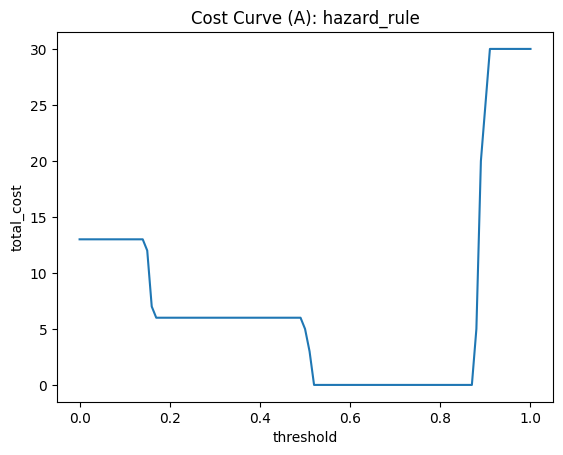

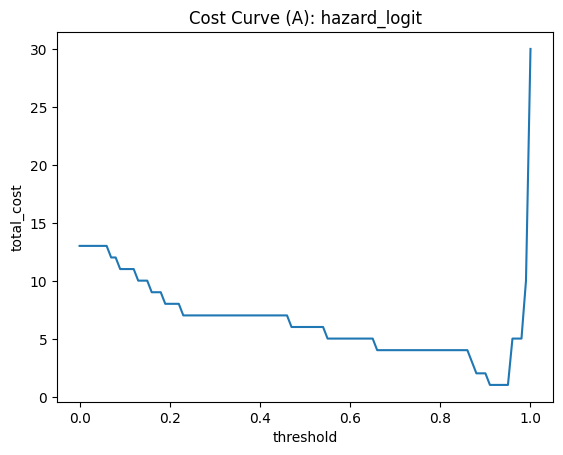

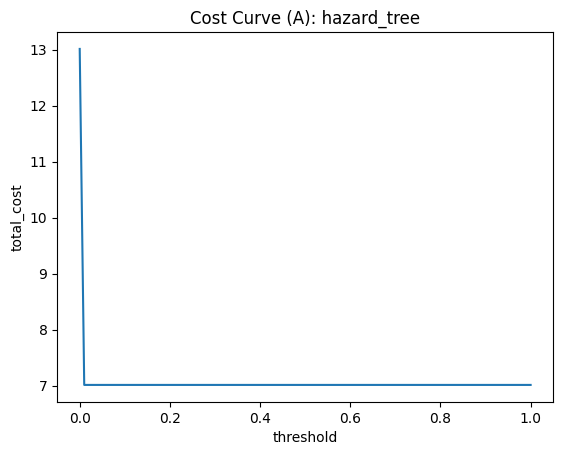

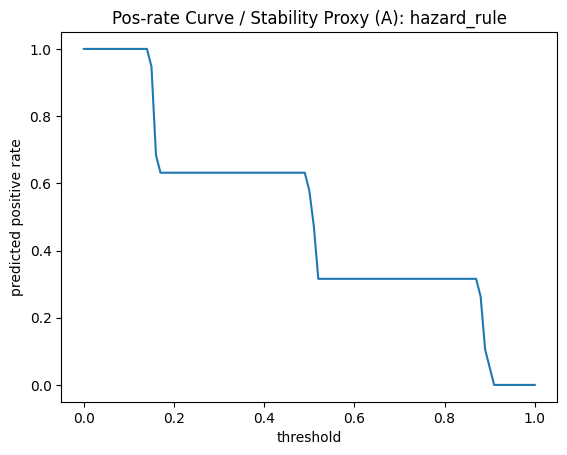

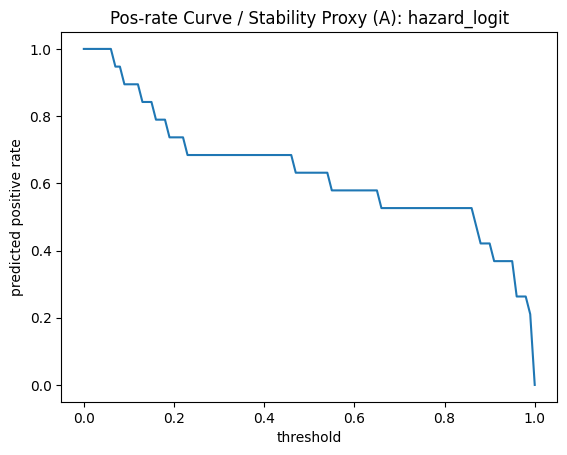

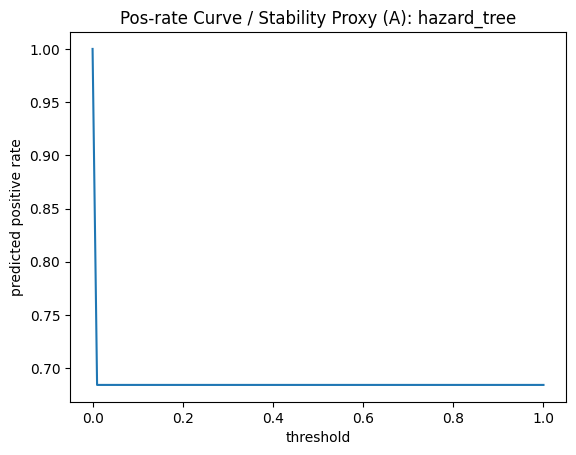

In [14]:
for hc in hazard_cols:
    sub = curve_all[curve_all["hazard_col"] == hc].copy()

    plt.figure()
    plt.plot(sub["threshold"], sub["total_cost"])
    plt.xlabel("threshold")
    plt.ylabel("total_cost")
    plt.title(f"Cost Curve ({PSEUDO_MODE}): {hc}")
    plt.show()

for hc in hazard_cols:
    sub = curve_all[curve_all["hazard_col"] == hc].copy()

    plt.figure()
    plt.plot(sub["threshold"], sub["pos_rate"])
    plt.xlabel("threshold")
    plt.ylabel("predicted positive rate")
    plt.title(f"Pos-rate Curve / Stability Proxy ({PSEUDO_MODE}): {hc}")
    plt.show()

In [15]:
lines = []
lines.append(f"Core10_05 calibrated thresholds under cost policy: FP={COST_FP}, FN={COST_FN}, stability_w={STABILITY_WEIGHT}.")
lines.append(f"Pseudo-failure mode={PSEUDO_MODE} using {LABEL_COL}. Quantile={PSEUDO_FAIL_QUANTILE:.2f}, threshold={FAIL_TH:.4f}.")

for _, r in best_df.iterrows():
    lines.append(
        f"- {r['hazard_col']}: th={r['threshold']:.2f}, total_cost={r['total_cost']:.2f}, "
        f"FP={int(r['fp'])}, FN={int(r['fn'])}, pos_rate={r['pos_rate']:.2f}, stab={r['stability_proxy']:.4f}"
    )

print("\n".join(lines))

Core10_05 calibrated thresholds under cost policy: FP=1.0, FN=5.0, stability_w=0.25.
Pseudo-failure mode=A using pseudo_failure_A. Quantile=0.30, threshold=0.7329.
- hazard_rule: th=0.52, total_cost=0.05, FP=0, FN=0, pos_rate=0.32, stab=0.0100
- hazard_logit: th=0.91, total_cost=1.05, FP=1, FN=0, pos_rate=0.37, stab=0.0100
- hazard_tree: th=0.01, total_cost=7.01, FP=7, FN=0, pos_rate=0.68, stab=0.0032
